## Model 3

### Sprint 2

#               <h1><center>Leading the Stroke Preventing Lifestyle</center></h1>
## <h2><center>Stroke Predictor</center></h2>    


# Table of Content
I.	Introduction.

II.	Data loading

III.	Exploratory data analysis.

IV.	Statistical Inference.

V.	Modeling.

VI.	Conclusions.

VII.	Recommendations.




# I. Introduction

The goal of this project is to define life style choices that should help prevent the stroke. In addition, I will create and deploy stroke prediction app with Streamlit. 

In addition, this project aims to:
1.	Practice identifying opportunities for data analysis, raising hypothesis, and formulating research tasks.
2.	Practice performing EDA, statistical inference, and prediction.
3.	Practice visualizing data.
4.  Practice machine learning modeling techniques.
5.  Practicing deploying the model for production.



Importing all the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_absolute_error,
    precision_score, recall_score, 
    f1_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import  LabelEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from scipy.stats import ttest_ind
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from collections import Counter
from typing import List
from pandas import DataFrame
from stroke_functions import evaluate_models, encode_categorical
import pickle


import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


# II.	Data loading

In [2]:
data = pd.read_csv("data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# III. Exploratory data analysis:
In EDA I will focus on the following project questions

1. Handling Missing Values

2. Handling Duplicates

3. Data Visualization: I will create various visualizations to understand the distribution, relationships, and patterns in the data. 

4. Outlier Detection: I will identify potential outliers in numerical data that significantly deviate from the rest of the observations, and then I will decide whether to keep or remove these outliers based on the context of the project.

5. Categorical Data Analysis: for categorical data, I will create plots to understand the distribution of each category.

6. Summary Statistics: Calculate descriptive statistics for numerical columns, such as mean, median, standard deviation, minimum, maximum, and quartiles. You can use the describe() function in pandas.

7. Feature Relationships: Explore relationships between different features/columns in the dataset. Use correlation matrices or pair plots to visualize correlations between numerical features.




## III.1. Handling Missing Values.
In this section I will review the content of the tables focusing on missing values.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are bmi index missing for 201 individuals. Before, decicing how to deal with the missing lines, I will check the correlation of bmi to the stroke column to understand its importance in the further data analysis and modeling.

In [4]:
bmi_corr = data["bmi"].corr(data["stroke"])
bmi_corr.round(3)

0.042

Since the correlation of BMI to target variable is weak, I will leave the values as blank. I will be using gradiant boosting model for the healthy lifestyle definition. This model handles missing values  naturally. For other models I will use simpleimputer, when needed.

## III.2. Handling Duplicates

The dataset has the ids of the individuals. Thus, I will check for the dublicating ids only.

In [5]:
duplicate_ids = data[data["id"].duplicated(keep=False)]
if duplicate_ids.empty:
    print("There are no duplicate ids in the dataset")
else:
    print("There are duplicate ids in the dataset")

There are no duplicate ids in the dataset


Each id is unique, this I asume that the dataset does not contain duplicates.
I will keep id column for outlier handing.

## III.3. Data Visualization - numeric values
Before reviewing the distributions of numeric data, I will split the dataset into two separate - one for those with stroke and the other without. This separation should help see the pattern difference between the two groups of people.

In [6]:
stroke_positive = data[data["stroke"] == 1]
stroke_negative = data[data["stroke"] == 0]
print(f"Stroke negative dataset is {len(stroke_negative)} rows long.")
print(f"Stroke positive dataset is {len(stroke_positive)} rows long.")
print(
    f"Stroke positive makes {len(stroke_positive)/len(data)*100:.2f} % of the total dataset."
)

Stroke negative dataset is 4861 rows long.
Stroke positive dataset is 249 rows long.
Stroke positive makes 4.87 % of the total dataset.


For visualization purposes I will separate categorical and numerical values. 

In [7]:
categorical_columns = [
    col
    for col in data.columns
    if (data[col].dtype != "int64" and data[col].dtype != "float64")
    or set(data[col].unique()) == {0, 1}
]
numeric_columns = [col for col in data.columns if col not in categorical_columns]
numeric_columns.pop(0)
categorical_columns

['gender',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'smoking_status',
 'stroke']

For numeric visualization I will use simple bar charts with stroke positive and stroke negative in the same chart for visual comparison.

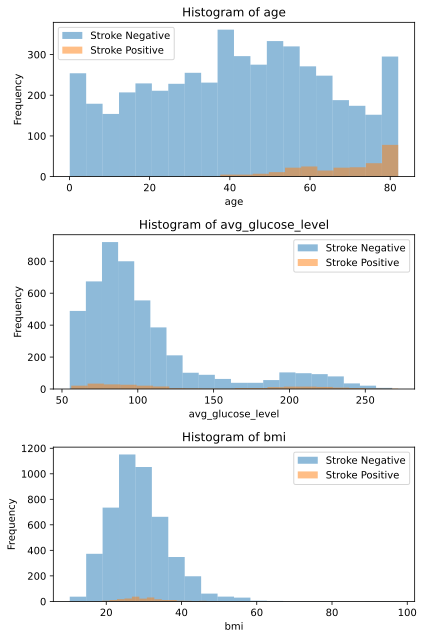

In [8]:
rows = len(numeric_columns)
cols = 1
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6,3*rows))
bins = 20
for idx, col in enumerate(numeric_columns):
    ax=axes[idx]
    stroke_negative[col].plot(kind='hist', ax=ax, alpha=0.5, label='Stroke Negative', bins = bins)
    stroke_positive[col].plot(kind='hist', ax=ax, alpha=0.5, label='Stroke Positive', bins = bins)
    
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()


plt.tight_layout()
plt.show()



Age distribution seems to be normal, but cases with stroke increase at about 40 years old. This issue needs to be addressed but before I will make the outlier analysis.
Glucosis chart also indicate some relationship between the lower and the higher glucoses levels and stroke, but this relationship will further be checked with correlation.

BMi index does not show strong correlation with the stroke occurance. In contrast, high BMI does not seem to have any stroke cases, which is a bit surprising.

Next, lets identify if any of the number columns have the outliers present.


## III. 4. Outlier Identification for numeric data

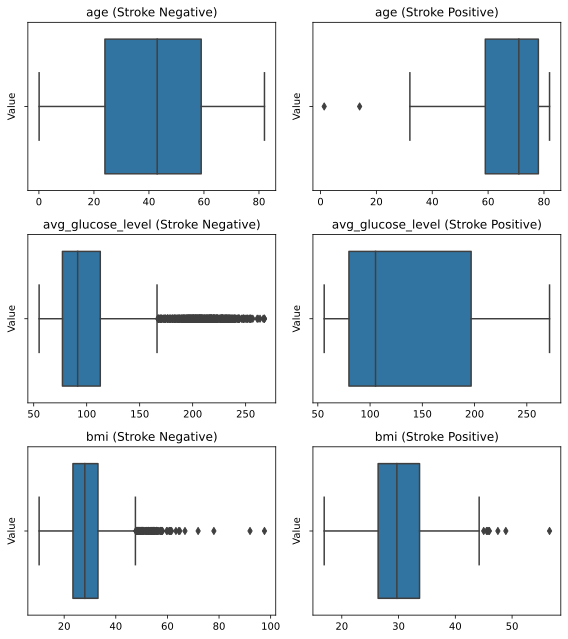

In [9]:
rows = len(numeric_columns)
cols = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 3 * rows))
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=stroke_negative, x=col,ax=axes[i,0])
    sns.boxplot(data=stroke_positive, x=col,ax=axes[i,1])
    axes[i, 0].set_title(f'{col} (Stroke Negative)')
    axes[i, 1].set_title(f'{col} (Stroke Positive)')
    axes[i, 0].set_xlabel('')
    axes[i, 1].set_xlabel('')
    axes[i, 0].set_ylabel('Value')
    axes[i, 1].set_ylabel('Value')
plt.tight_layout()
plt.show()


Boxplots point that there are outliers in both data groups. I want to eliminate them by creating a new dataframe, which I will be using for futher analysis and modeling.

In [10]:
outlier_threshold = 1.5

outlier_ids_positive = []
outlier_ids_negative = []
outlier_ids = []

for col in numeric_columns:
    Q1_pos = stroke_positive[col].quantile(0.25)
    Q3_pos = stroke_positive[col].quantile(0.75)
    IQR_pos = Q3_pos - Q1_pos
    lower_bound_pos = Q1_pos - outlier_threshold * IQR_pos
    upper_bound_pos = Q3_pos + outlier_threshold * IQR_pos

    outliers_in_col_pos = (stroke_positive[col] < lower_bound_pos) | (
        stroke_positive[col] > upper_bound_pos
    )
    outlier_ids_positive.extend(stroke_positive[outliers_in_col_pos]["id"].tolist())

for col in numeric_columns:
    Q1_neg = stroke_negative[col].quantile(0.25)
    Q3_neg = stroke_negative[col].quantile(0.75)
    IQR_neg = Q3_neg - Q1_neg
    lower_bound_neg = Q1_neg - outlier_threshold * IQR_neg
    upper_bound_neg = Q3_neg + outlier_threshold * IQR_neg

    outliers_in_col_neg = (stroke_negative[col] < lower_bound_neg) | (
        stroke_negative[col] > upper_bound_neg
    )
    outlier_ids_negative.extend(stroke_negative[outliers_in_col_neg]["id"].tolist())

for col in numeric_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - outlier_threshold * IQR
    upper_bound = Q3 + outlier_threshold * IQR

    outliers_in_col = (data[col] < lower_bound) | (data[col] > upper_bound)
    outlier_ids.extend(data[outliers_in_col]["id"].tolist())

outlier_ids_combined = outlier_ids_positive + outlier_ids_negative + outlier_ids

normal_data = data[~data["id"].isin(outlier_ids_combined)]

len(normal_data)

4390

In [11]:
stroke_positive_new = normal_data[normal_data["stroke"] == 1]
stroke_negative_new = normal_data[normal_data["stroke"] == 0]

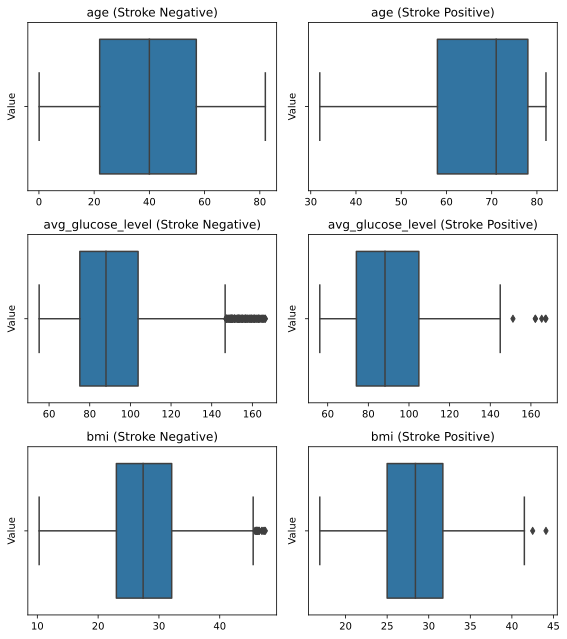

In [12]:
rows = len(numeric_columns)
cols = 2
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8, 3 * rows))
for i, col in enumerate(numeric_columns):
    sns.boxplot(data=stroke_negative_new, x=col,ax=axes[i,0])
    sns.boxplot(data=stroke_positive_new, x=col,ax=axes[i,1])
    axes[i, 0].set_title(f'{col} (Stroke Negative)')
    axes[i, 1].set_title(f'{col} (Stroke Positive)')
    axes[i, 0].set_xlabel('')
    axes[i, 1].set_xlabel('')
    axes[i, 0].set_ylabel('Value')
    axes[i, 1].set_ylabel('Value')
plt.tight_layout()
plt.show()


Some outliers remain, but this is acceptable.

## III.5. Categorical data analysis

I will map some some of the numericly represented categories to a more user friendly naming. Also, one case has other than male or female, so I eliminate this row.

In [80]:
categorical_columns
normal_data["stroke"] = normal_data["stroke"].map({0: "No", 1: "Yes"})
normal_data["hypertension"] = normal_data["hypertension"].map({0: "No", 1: "Yes"})
normal_data["heart_disease"] = normal_data["heart_disease"].map({0: "No", 1: "Yes"})

normal_data = normal_data[normal_data["gender"].isin(["Male", "Female"])].copy()
normal_data.head()


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,stroke_encoded
2,Male,80.0,NaN,NaN,Yes,Private,Rural,105.92,32.5,never smoked,NaN,1
6,Male,74.0,NaN,NaN,Yes,Private,Rural,70.09,27.4,never smoked,NaN,1
7,Female,69.0,NaN,NaN,No,Private,Urban,94.39,22.8,never smoked,NaN,1
8,Female,59.0,NaN,NaN,Yes,Private,Rural,76.15,NaN,Unknown,NaN,1
9,Female,78.0,NaN,NaN,Yes,Private,Urban,58.57,24.2,Unknown,NaN,1


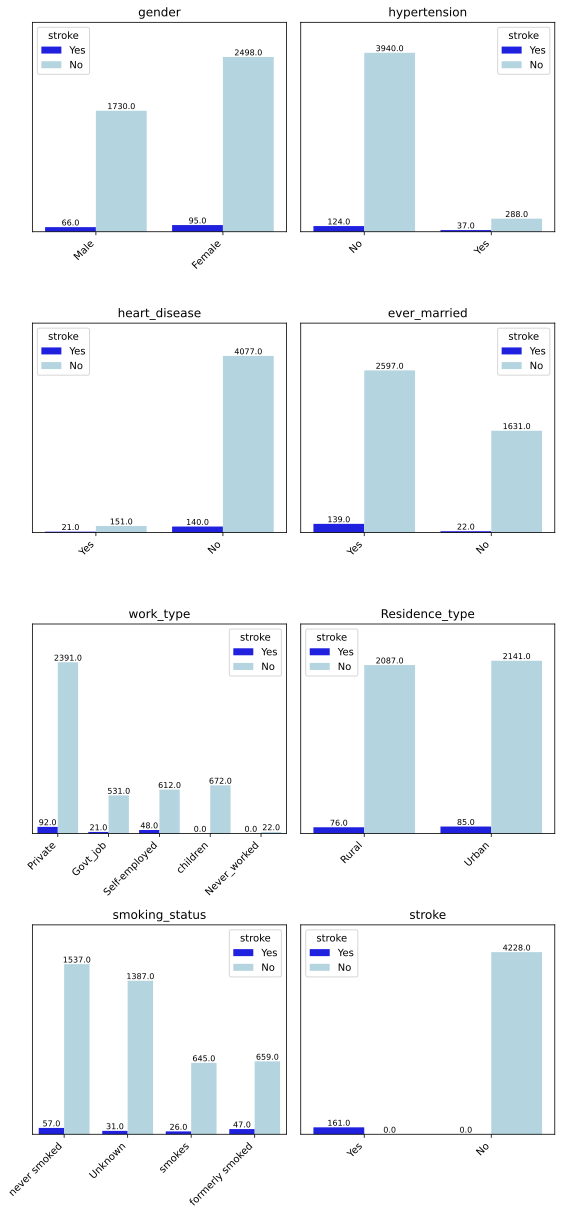

In [14]:

nrows = 4
ncols = 2
colors = ['blue', 'lightblue']
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 17))
for i, col in enumerate(categorical_columns):
    row = i // ncols
    cols = i % ncols
    ax = axes[row, cols]

    if not data[col].any():
        ax.set_axis_off()
    else:
        sns.countplot(data=normal_data, x=col, hue="stroke", ax=ax, palette = colors)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_yticks([])

        total = len(data)
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(
                f"{height}",
                (p.get_x() + p.get_width() / 2.0, height),
                ha="center",
                va="bottom",
                fontsize=8,
            )

    ax.set_title(f"{col}")

    max_count = max(data[col].value_counts())
    ax.set_ylim(0, max_count)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

I will show percentage value of stroke cases separately.

In [15]:
total_stroke_cases = (normal_data['stroke'] == "Yes").sum()

total_no_stroke_cases = len(normal_data) - total_stroke_cases

percentage_stroke = (total_stroke_cases / len(normal_data)) * 100
percentage_no_stroke = (total_no_stroke_cases / len(normal_data)) * 100

print(f"Percentage of cases with stroke: {percentage_stroke.item():.2f}%")
print(f"Percentage of cases without stroke: {percentage_no_stroke.item():.2f}%")

Percentage of cases with stroke: 3.67%
Percentage of cases without stroke: 96.33%


I want to visualize the distribution of categories in percentages. Thus, I will create a separate data frame for this purpose.

In [16]:
cat = normal_data[categorical_columns]
columns1 = cat.columns[:-1]

result = pd.DataFrame()


result['column1'] = [col for cols in columns1 for col in [cols] * len(cat)]
result['column2'] = cat.iloc[:, :-1].values.ravel()

grouped = cat.groupby(list(columns1))['stroke'].value_counts().unstack(fill_value=0)

grouped.reset_index(inplace=True)

grouped = grouped.rename_axis(None, axis=1)

new_rows = []

for col in grouped.columns[:-2]:
    
    unique_values = grouped[col].unique()
    
    
    for value in unique_values:
        
        filtered_group = grouped[grouped[col] == value]
        
        
        total_yes = filtered_group['Yes'].sum()
        total_no = filtered_group['No'].sum()
        
        
        new_row = {
            'group': col,
            'category': value,
            'stroke_yes': total_yes,
            'stroke_no': total_no
        }
        
        
        new_rows.append(new_row)

new_df = pd.concat([pd.DataFrame([row]) for row in new_rows], ignore_index=True)
new_df['stroke_total'] = new_df['stroke_yes']+new_df['stroke_no']
new_df['yes_%'] = round((new_df['stroke_yes'] / new_df['stroke_total']) * 100,2)
new_df['no_%'] = round((new_df['stroke_no'] / new_df['stroke_total']) * 100,2)
new_df.head()


,group,category,stroke_yes,stroke_no,stroke_total,yes_%,no_%
0,gender,Female,95,2498,2593,3.66,96.34
1,gender,Male,66,1730,1796,3.67,96.33
2,hypertension,No,124,3940,4064,3.05,96.95
3,hypertension,Yes,37,288,325,11.38,88.62
4,heart_disease,No,140,4077,4217,3.32,96.68


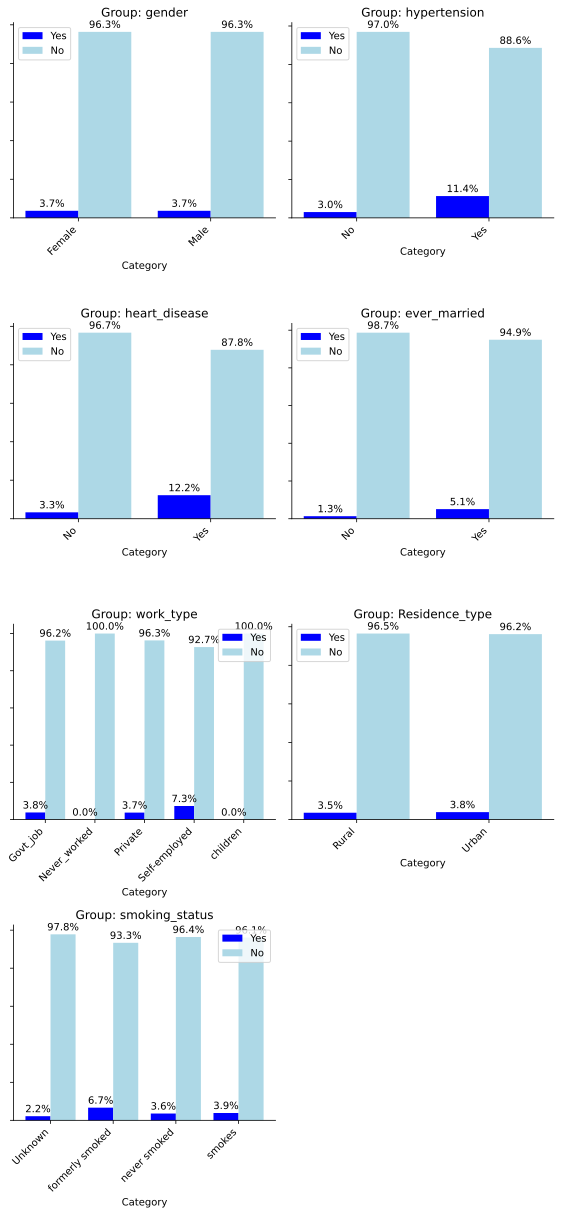

In [17]:
nrows = 4
ncols = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 17))

axes = axes.flatten()
sns.despine(top=True, left=False)
unique_groups = new_df['group'].unique()
for i, group_value in enumerate(unique_groups):
    ax = axes[i]
        
    group_data = new_df[new_df['group'] == group_value]
        
    total_width = 0.8
        
    bar_width = total_width / 2
        
    positions = list(range(len(group_data)))
    positions_yes = [pos - bar_width/2 for pos in positions]
    positions_no = [pos + bar_width/2 for pos in positions]
        
    ax.bar(positions_yes, group_data['yes_%'], width=bar_width, color='blue', label='Yes')
       
    ax.bar(positions_no, group_data['no_%'], width=bar_width, color='lightblue', label='No')
        
    ax.set_xlabel('Category')
    ax.set_title(f'Group: {group_value}')
    ax.set_xticks(positions)
    ax.set_xticklabels(group_data['category'], rotation=45, ha='right')
    ax.set_yticklabels([])
    ax.legend()
    
    
    for p_yes, p_no, yes_percent, no_percent in zip(positions_yes, positions_no, group_data['yes_%'], group_data['no_%']):
        ax.text(p_yes, yes_percent + 1, f'{yes_percent:.1f}%', ha='center', va='bottom', color='black')
        ax.text(p_no, no_percent + 1, f'{no_percent:.1f}%', ha='center', va='bottom', color='black')


for i in range(len(unique_groups), nrows * ncols):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()



Categorical data analysis and their distribution of those with and without stroke revieled that gender does not have a significant effect. Marriage does, just as self and private employments. Smoking also does not seem to have for strong effect, except for those who formerly smoked. It would seems that it is better to keep smoking rather than quiting. Rural residency has a very minimal effect on stroke potential minimization.

The highest riskfactors are hyptertension and heart diseased. This is an interesting observation for further analysis. 

## III.6. Summary Statistics

Basic statistic of numeric features.

In [18]:
st_data = normal_data.drop('id', axis=1)
summary_stats = st_data.describe().T
summary_stats = summary_stats.round(1)
summary_stats

,count,mean,std,min,25%,50%,75%,max
age,4389.0,40.9,22.5,0.1,23.0,42.0,58.0,82.0
avg_glucose_level,4389.0,91.4,22.4,55.1,75.1,88.0,103.9,167.4
bmi,4250.0,27.8,6.7,10.3,23.0,27.4,32.1,47.5


The mean of age, glucose level, and BMI point to a average normal health people group. Thus, only 3.6% of total group had stroke. The dataset will need to be balanced for modeling.

## III.7. Feature Relationships

Before analyzing feature relationship I will encode the data to give numeric values the categorical data.

Before encoding:

In [19]:
normal_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,31112,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,Yes
6,53882,Male,74.0,Yes,Yes,Yes,Private,Rural,70.09,27.4,never smoked,Yes
7,10434,Female,69.0,No,No,No,Private,Urban,94.39,22.8,never smoked,Yes
8,27419,Female,59.0,No,No,Yes,Private,Rural,76.15,NaN,Unknown,Yes
9,60491,Female,78.0,No,No,Yes,Private,Urban,58.57,24.2,Unknown,Yes


In [20]:
str_categorical_columns = [
    col
    for col in normal_data.columns
    if (normal_data[col].dtype != "int64" and normal_data[col].dtype != "float64")
]
str_categorical_columns.remove('stroke')
label_encoders = {}
le = LabelEncoder()
num_data = normal_data.copy()
for column in str_categorical_columns:
    num_data[column] = le.fit_transform(num_data[column])
    label_encoders[column] = le
num_data["stroke"] = num_data["stroke"].map({"No": 0, "Yes": 1})
num_data.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
6,53882,1,74.0,1,1,1,2,0,70.09,27.4,2,1
7,10434,0,69.0,0,0,0,2,1,94.39,22.8,2,1
8,27419,0,59.0,0,0,1,2,0,76.15,NaN,0,1
9,60491,0,78.0,0,0,1,2,1,58.57,24.2,0,1


Correlation analysis of encoded data.

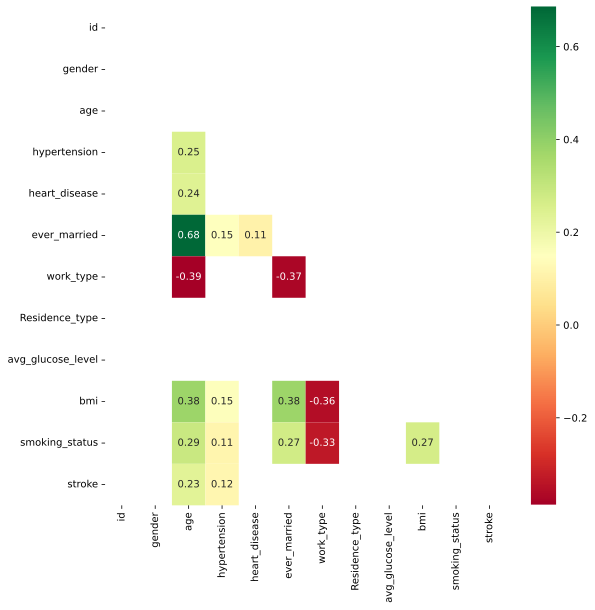

In [21]:
corr = num_data.corr()
plt.figure(figsize=(9, 9))
mask1 = np.triu(np.ones_like(corr, dtype=bool))
mask2 = (abs(corr)<0.1)
mask = mask1 | mask2
sns.heatmap(corr, annot=True, cmap="RdYlGn", mask=mask)
plt.show()

The correlation analysis displayed very weak links between various factors and stroke. The only feature that has moderate correlation with the stroke is age. Thus, correlation analysis did not help me identify, which parameters in fact have strong affect on the stroke potential. 

Out of all the features, other than age, huypertension, heart disease, mariage history, and clucose_level have weak correlation with the stroke potential. Intuitively, I want to check statictical significance of hypertension, heart disease, and glucose level to the stroke potential. These three factors, although have a weak correlation, they are health related features that might be interesting to investigate further. 

# IV. Statistical Inference

I will check statistical significance for three different health factors (hypertension, heart disease, average glucose level) and the stroke occurance. 

Null Hypothesis (H0): There is no significant association between hypertension, heart disease, average glucose level, and the occurrence of stroke.

Alternative Hypothesis (H1): There is a significant association between at least one of the health factors (hypertension, heart disease, or average glucose level) and the occurrence of stroke.

Alpha = 0.05

In [22]:
import statsmodels.api as sm

data_with_const = sm.add_constant(num_data[['hypertension', 'heart_disease', 'avg_glucose_level']])

response = num_data['stroke']

logit_model = sm.Logit(response, data_with_const)
result = logit_model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.150633
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 stroke   No. Observations:                 4389
Model:                          Logit   Df Residuals:                     4385
Method:                           MLE   Df Model:                            3
Date:                Thu, 31 Aug 2023   Pseudo R-squ.:                 0.04211
Time:                        20:42:47   Log-Likelihood:                -661.13
converged:                       True   LL-Null:                       -690.19
Covariance Type:            nonrobust   LLR p-value:                 1.479e-12
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.6576      0.342    -10.708      0.000      -4.327      -2.988
hyperten

The logistic regression model suggests that two health factors, hypertension and heart disease, are statistically significantly associate to stroke. While, glucose level is not.  Lets also perform standard t-test.

In [23]:
stroke_yes = num_data[num_data['stroke'] == 1]
stroke_no = num_data[num_data['stroke'] == 0]

health_factors = ['hypertension', 'heart_disease', 'avg_glucose_level']
results = {}

for factor in health_factors:
    t_stat, p_value = ttest_ind(stroke_yes[factor], stroke_no[factor])
    results[factor] = {'t_statistic': t_stat, 'p_value': p_value}


for factor, result in results.items():
    print(f"Health Factor: {factor}")
    print(f"T-Statistic: {result['t_statistic']:.4f}")
    print(f"P-Value: {result['p_value']:.4f}")
    print("")

    if result['p_value'] < 0.05:
        print(f"The {factor} is statistically significant in relation to stroke.")
    else:
        print(f"The {factor} is not statistically significant in relation to stroke.")
    print("=============================")


Health Factor: hypertension
T-Statistic: 7.7409
P-Value: 0.0000

The hypertension is statistically significant in relation to stroke.
Health Factor: heart_disease
T-Statistic: 6.1035
P-Value: 0.0000

The heart_disease is statistically significant in relation to stroke.
Health Factor: avg_glucose_level
T-Statistic: 0.3687
P-Value: 0.7124

The avg_glucose_level is not statistically significant in relation to stroke.


The t-test returned the same results as logistic regression test. Thus I conclude that hypertension and heart disease are asociated with the stoke potential, while glucoses level, no.

Further, I will train the machine learning models to predict the stroke, as well as permutation analysis to see, which factors affect the stroke potential the most.

# 5. Modeling
The result of the modeling is categorical - either a person has a storke or does not. Thus, I will be using categorization models, such as logistic regression, decision tree, random forest, and support vector calsification. In addition, I will use ensemble model xgboost. 

For the modeling part I will build the pipeline, which would consist of the following steps:

1. Filling the blank values.
2. Tranforming categorical values into numeric.
3. Standartizing the values with standart scaler.
4. Training various models.
5. Checking model accuracy.

Since I will be testing the models in several different ways, I will create the function for modeling. The function is place in the stroke_functions.py file and imported into this notebook.

First, I will evaluate the result on original data set.

In [24]:
normal_data = normal_data.drop('id', axis=1).copy()
normal_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,Yes
6,Male,74.0,Yes,Yes,Yes,Private,Rural,70.09,27.4,never smoked,Yes
7,Female,69.0,No,No,No,Private,Urban,94.39,22.8,never smoked,Yes
8,Female,59.0,No,No,Yes,Private,Rural,76.15,NaN,Unknown,Yes
9,Female,78.0,No,No,Yes,Private,Urban,58.57,24.2,Unknown,Yes


In [25]:
categorical_columns.remove('stroke')
categorical_columns, numeric_columns

(['gender',
  'hypertension',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type',
  'smoking_status'],
 ['age', 'avg_glucose_level', 'bmi'])

In [26]:
results = evaluate_models(normal_data, categorical_columns, numeric_columns)
print(results)

                 Model  Accuracy  Precision   Recall        F1
0  Logistic Regression  0.963554   0.000000  0.00000  0.000000
1        Decision Tree  0.932802   0.064516  0.06250  0.063492
2        Random Forest  0.963554   0.000000  0.00000  0.000000
3                  SVM  0.963554   0.000000  0.00000  0.000000
4              XGBoost  0.956720   0.250000  0.09375  0.136364


The accuracy of the modeling is high, however, precision and recall is very low. The model is clearly underfit.

Few reason - high data disbalance, and unimportant features. So first, I will balance the data set. 

1. First, I will populate the positive stroke cases with Random Oversampling technique.
2. Then I will depopulate the negative stroke cases with Random Undersampling technique.

In [27]:
normal_data['stroke'].value_counts()

No     4228
Yes     161
Name: stroke, dtype: int64

In [28]:
X = normal_data.drop(['stroke'], axis=1)
y = normal_data['stroke']

print("Original class distribution:", Counter(y))

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=25)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

print("Oversampled class distribution:", Counter(y_resampled))

oversampled_data = pd.concat([X_resampled, y_resampled], axis=1)


Original class distribution: Counter({'No': 4228, 'Yes': 161})
Oversampled class distribution: Counter({'Yes': 4228, 'No': 4228})


In [29]:
oversampled_data['stroke'].value_counts()

Yes    4228
No     4228
Name: stroke, dtype: int64

In [30]:
results = evaluate_models(oversampled_data, categorical_columns, numeric_columns)
print("Oversampled data results")
print(results)

Oversampled data results
                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.758274   0.738202  0.788715  0.762623
1        Decision Tree  0.982861   0.966357  1.000000  0.982891
2        Random Forest  0.993499   0.986967  1.000000  0.993441
3                  SVM  0.874704   0.815228  0.963986  0.883388
4              XGBoost  0.981678   0.964120  1.000000  0.981732


The Oversampled data set returned recall close or sometime equal to 1, which points to overfiting of the model. Now, I will underpopulate the data.

In [31]:
X = normal_data.drop(['stroke'], axis=1)
y = normal_data['stroke']

print("Original class distribution:", Counter(y))

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=69)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print("Undersampled class distribution:", Counter(y_resampled))

undersampled_data = pd.concat([X_resampled, y_resampled], axis=1)

Original class distribution: Counter({'No': 4228, 'Yes': 161})
Undersampled class distribution: Counter({'No': 161, 'Yes': 161})


In [32]:
results = evaluate_models(undersampled_data, categorical_columns, numeric_columns)
print("Undersampled data results")
print(results)

Undersampled data results
                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.707692   0.625000  0.740741  0.677966
1        Decision Tree  0.646154   0.566667  0.629630  0.596491
2        Random Forest  0.692308   0.594595  0.814815  0.687500
3                  SVM  0.692308   0.606061  0.740741  0.666667
4              XGBoost  0.707692   0.625000  0.740741  0.677966


Undersampling the data returned very nice recall result. Surprisingly, xgboost performed as well ans logistic regression. Before deciding on the model for deployment, I will peform permutation analysis.

In [33]:
import eli5
from eli5.sklearn import PermutationImportance

label_encoder = LabelEncoder()
normal_data['stroke_encoded'] = label_encoder.fit_transform(normal_data['stroke'])

X = normal_data.drop(['stroke', 'stroke_encoded'], axis=1)
y = normal_data['stroke_encoded']

new_cat_columns = [col for col in categorical_columns if col != 'stroke']
X = pd.get_dummies(X, columns=new_cat_columns)

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=69)

clf = XGBClassifier(random_state=69)
clf.fit(X_train, y_train)

perm_importance = PermutationImportance(clf, random_state=42)
perm_importance.fit(X_test, y_test)

results_df = eli5.formatters.as_dataframe.explain_weights_df(perm_importance, feature_names=X.columns.tolist())

results_df = results_df.sort_values(by='weight', ascending=False)

print(results_df)


                           feature        weight       std
0                  ever_married_No  1.594533e-03  0.000558
1                work_type_Private  1.594533e-03  0.000558
2                              age  1.138952e-03  0.003455
3                  hypertension_No  2.277904e-04  0.001328
4      smoking_status_never smoked  2.277904e-04  0.001328
5          work_type_Self-employed  2.277904e-04  0.000456
6                 heart_disease_No  2.277904e-04  0.000456
7            smoking_status_smokes  2.220446e-17  0.000720
14                ever_married_Yes  0.000000e+00  0.000000
13                     gender_Male  0.000000e+00  0.000000
12                hypertension_Yes  0.000000e+00  0.000000
11               heart_disease_Yes  0.000000e+00  0.000000
10            Residence_type_Urban  0.000000e+00  0.000000
9           work_type_Never_worked  0.000000e+00  0.000000
8               work_type_children  0.000000e+00  0.000000
15          smoking_status_Unknown -2.277904e-04  0.0004

Based on permuation importance analysis, I see that age, hypertention, smoking status, marital status, bmi, heart disease, avg glucose level, and gender has somewhat positive or negative weights in the model. I will create a separate df with these features, underpupolate it, and perform model analysis.

In [34]:
selected_columns = ['age', 'hypertension', 'ever_married', 'smoking_status', 'stroke', 'bmi', 'work_type', 'heart_disease', 'avg_glucose_level']
reduced_data = normal_data[selected_columns].copy()
reduced_data.head()

,age,hypertension,ever_married,smoking_status,stroke,bmi,work_type,heart_disease,avg_glucose_level
2,80.0,No,Yes,never smoked,Yes,32.5,Private,Yes,105.92
6,74.0,Yes,Yes,never smoked,Yes,27.4,Private,Yes,70.09
7,69.0,No,No,never smoked,Yes,22.8,Private,No,94.39
8,59.0,No,Yes,Unknown,Yes,NaN,Private,No,76.15
9,78.0,No,Yes,Unknown,Yes,24.2,Private,No,58.57


In [35]:
X = reduced_data.drop(['stroke'], axis=1)
y = reduced_data['stroke']

print("Original class distribution:", Counter(y))

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=69)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print("Undersampled class distribution:", Counter(y_resampled))

reduced_undersampled_data = pd.concat([X_resampled, y_resampled], axis=1)

Original class distribution: Counter({'No': 4228, 'Yes': 161})
Undersampled class distribution: Counter({'No': 161, 'Yes': 161})


In [36]:
num_columns = ['age', 'bmi', 'avg_glucose_level']
cat_columns = ['hypertension', 'ever_married', 'smoking_status','work_type', 'heart_disease']
results = evaluate_models(reduced_undersampled_data, cat_columns, num_columns)
print("Undersampled data results")
print(results)

Undersampled data results
                 Model  Accuracy  Precision    Recall        F1
0  Logistic Regression  0.723077   0.645161  0.740741  0.689655
1        Decision Tree  0.584615   0.500000  0.592593  0.542373
2        Random Forest  0.661538   0.571429  0.740741  0.645161
3                  SVM  0.723077   0.636364  0.777778  0.700000
4              XGBoost  0.738462   0.647059  0.814815  0.721311


Permutation analysis showed worse results. 

Since I am looking for the model with the highest recall and accuracy value, undersampled balanced full data test revealed that xgboost model performed the best. Thus, I will continue working with this model for hyperparameter tuning using Grid Search method.

Next, I will perform hyperparameter tuning

In [70]:
data['stroke'] = data['stroke'].map({1: "Yes", 0: 'No'})
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,Yes
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,Yes
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,Yes
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,Yes
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,Yes


In [71]:
num_columns = ['age', 'bmi', 'avg_glucose_level']
cat_columns = ['hypertension', 'ever_married', 'smoking_status','work_type', 'heart_disease', 'stroke']

selected_columns = num_columns + cat_columns
data_selected = data[selected_columns]
data_selected.head()


,age,bmi,avg_glucose_level,hypertension,ever_married,smoking_status,work_type,heart_disease,stroke
0,67.0,36.6,228.69,0,Yes,formerly smoked,Private,1,Yes
1,61.0,NaN,202.21,0,Yes,never smoked,Self-employed,0,Yes
2,80.0,32.5,105.92,0,Yes,never smoked,Private,1,Yes
3,49.0,34.4,171.23,0,Yes,smokes,Private,0,Yes
4,79.0,24.0,174.12,1,Yes,never smoked,Self-employed,0,Yes


Recall value is the best with these parameterhyperparameters. 

In [81]:
encoded_data= encode_categorical(data_selected, cat_columns)
encoded_data.head()

c:\Users\DeivydasPagojus\OneDrive - Business finance, MB\Documents\My stuff\Turing\M3S2\stroke_functions.py:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Yes' in unique_values and 'No' in unique_values:
c:\Users\DeivydasPagojus\OneDrive - Business finance, MB\Documents\My stuff\Turing\M3S2\stroke_functions.py:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'Yes' in unique_values and 'No' in unique_values:


,age,bmi,avg_glucose_level,hypertension,ever_married,smoking_status,work_type,heart_disease,stroke
0,67.0,36.6,228.69,0,1,0,0,0,1
1,61.0,NaN,202.21,0,1,1,1,1,1
2,80.0,32.5,105.92,0,1,1,0,0,1
3,49.0,34.4,171.23,0,1,2,0,1,1
4,79.0,24.0,174.12,1,1,1,1,1,1


In [73]:
X = encoded_data.drop(['stroke'], axis=1)
y = encoded_data['stroke']

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = undersampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=69)

param_grid = {
    'n_estimators': [5, 10, 20],
    'max_depth': [4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2]
}

model = XGBClassifier()

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='recall',
    cv=10,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Hyperparameters: {'n_estimators': 10, 'max_depth': 4, 'learning_rate': 0.1}
Best Score: 0.8452380952380951


In [74]:
best_estimator = random_search.best_estimator_
best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
recall = recall_score(y_test, y_pred)
print("Recall Score:", recall)


Recall Score: 0.9523809523809523


After fitting the model with hyperparameters, the recall value improved. Perhaps this is because of the random state. The value is very high. 

I will test the model on the assummed user input data.

In [75]:
user_input_dict = {
    'age': 54,
    'bmi': 29,
    'avg_glucose_level': 200,
    'hypertension': 'No',
    'ever_married': 'Yes',
    'smoking_status': 'smokes',
    'work_type': 'Private',
    'heart_disease': 'Yes'   
}
default_dict = {'stroke': 'No'}
merged_dict = user_input_dict.copy()
merged_dict.update(default_dict)

cat_columns2 = ['hypertension', 'ever_married', 'smoking_status', 'work_type', 'heart_disease', 'stroke']
user_input_df = pd.DataFrame([merged_dict])
encoded_data= encode_categorical(user_input_df, cat_columns2)
encoded_data = encoded_data.drop(columns=['stroke'])
y_pred = best_estimator.predict(encoded_data)

print("Predicted Stroke:", y_pred)

Predicted Stroke: [1]


I will store the model into pickle file for deploying.

In [76]:
data = {"model": best_estimator}
with open('model_steps.pkl', 'wb') as f:
    pickle.dump(data, f)

Now, I will call the function and test it.

In [77]:
with open('model_steps.pkl', 'rb') as f:
    data = pickle.load(f)
    
test_mod = data['model'] 

In [78]:
user_input_dict = {
    'age': 54,
    'bmi': 29,
    'avg_glucose_level': 200,
    'hypertension': 'No',
    'ever_married': 'Yes',
    'smoking_status': 'smokes',
    'work_type': 'Private',
    'heart_disease': 'Yes'   
}
default_dict = {'stroke': 'No'}
merged_dict = user_input_dict.copy()
merged_dict.update(default_dict)

cat_columns2 = ['hypertension', 'ever_married', 'smoking_status', 'work_type', 'heart_disease', 'stroke']
user_input_df = pd.DataFrame([merged_dict])
encoded_data= encode_categorical(user_input_df, cat_columns2)
encoded_data = encoded_data.drop(columns=['stroke'])
y_pred = test_mod.predict(encoded_data)

print("Predicted Stroke:", y_pred)

Predicted Stroke: [1]


I got the same result. The model is well saved and can be used in production.

Based on various modeling and parameter techniques the xgboost ensemling model performes the best, although in many cases corresponds to logistic regression. Choosing specific paramenters reduces the performance of all models. 

Balancing the dataset with undersampling, greatly improved recall value. I will deploy underpopulated xboost model into production.

I will additionally create the lists of values for chosen categories so that they could be used in streamlit application.

In [79]:
cat_columns2 = ['hypertension', 'ever_married', 'smoking_status', 'work_type', 'heart_disease','stroke']
unique_values_dict = {}
for col in cat_columns2:
    unique_values = data_selected[col].unique().tolist()
    unique_values_dict[col] = unique_values

for col, unique_values in unique_values_dict.items():
    print(f"{col}: {unique_values}")

hypertension: [0, 1]
ever_married: ['Yes', 'No']
smoking_status: ['formerly smoked', 'never smoked', 'smokes', 'Unknown']
work_type: ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
heart_disease: [1, 0]
stroke: ['Yes', 'No']


# VI. Conclusion

EDA, statistical, and modeling analysis all pointed to the following factors that might influence stroke the most: heart disease, hypertension, age, and somewhat smoking, especially smoking in the past. Other factors has less influence. Thus, regular exercising, healthy diet, and never smoking can serve as preventative factors.




## VII. Recomendations
I would add alcohol usage as an important parameter, since alcohol consumption tends to create blood clots, and those clots are the main cause of the stroke. Thus, for a better prediction, alcohol habits should be included.